In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#|hide
from nbdev import show_doc, nbdev_export

# IR evaluation metrics with uncertainty estimates

> Compare different metrics and their uncertainty in the passage ranking dataset.

When working with search engine apps, be it a text search or a recommendation system, part of the job is doing experiments around components such as ranking functions and deciding which experiments deliver the best result.

This tutorial builds a text search app with [Vespa](https://vespa.ai/), feeds a sample of the passage ranking dataset to the app, and evaluates two ranking functions across three different metrics. **In addition to return point estimates of the evaluation metrics, we compute confidence intervals as illustrated in the plot below**. Measuring uncertainty around the metric estimates gives us a better sense of how significant is the impact of our changes in the application.

![](resources/passage/passage_uncertainty.png)

The code and the data used in this end-to-end tutorial are available and can be reproduced in a Jupyter Notebook.

## Create the Vespa application package

Create a Vespa application package to perform passage ranking experiments using the `create_basic_search_package`.

In [ ]:
from learntorank.passage import create_basic_search_package

app_package = create_basic_search_package()

We can inspect how the [Vespa search definition](https://docs.vespa.ai/en/schemas.html) file looks like:

In [ ]:
print(app_package.schema.schema_to_text)

schema PassageRanking {
    document PassageRanking {
        field doc_id type string {
            indexing: attribute | summary
        }
        field text type string {
            indexing: index | summary
            index: enable-bm25
        }
    }
    fieldset default {
        fields: text
    }
    rank-profile bm25 {
        first-phase {
            expression: bm25(text)
        }
        summary-features {
            bm25(text)
        }
    }
    rank-profile native_rank {
        first-phase {
            expression: nativeRank(text)
        }
    }
}


In this tutorial, we are going to compare two ranking functions. One is based on [NativeRank](https://docs.vespa.ai/en/reference/nativerank.html), and the other is based on [BM25](https://docs.vespa.ai/en/reference/bm25.html).

## Deploy the application

Deploy the application package in a Docker container for local development. Alternatively, it is possible to deploy the application package to [Vespa Cloud](https://pyvespa.readthedocs.io/en/latest/deploy-vespa-cloud.html).

In [ ]:
from vespa.deployment import VespaDocker

vespa_docker = VespaDocker()
app = vespa_docker.deploy(application_package=app_package)

Waiting for configuration server, 0/300 seconds...
Waiting for configuration server, 5/300 seconds...
Waiting for application status, 0/300 seconds...
Waiting for application status, 5/300 seconds...
Waiting for application status, 10/300 seconds...
Waiting for application status, 15/300 seconds...
Waiting for application status, 20/300 seconds...
Waiting for application status, 25/300 seconds...
Waiting for application status, 30/300 seconds...
Waiting for application status, 35/300 seconds...
Finished deployment.


Once the deployment is finished, we can interact with the deployed application through the `app` variable.

## Get sample data

We can load passage ranking sample data with `PassageData.load`. By default, it will download pre-generated sample data.

In [ ]:
from learntorank.passage import PassageData

data = PassageData.load()

In [ ]:
data

PassageData(corpus, train_qrels, train_queries, dev_qrels, dev_queries)

In [ ]:
data.summary

Number of documents: 1000
Number of train queries: 100
Number of train relevance judgments: 100
Number of dev queries: 100
Number of dev relevance judgments: 100


## Feed the application

Get the document corpus in a `DataFrame` format.

In [ ]:
corpus_df = data.get_corpus()
corpus_df.head()

,doc_id,text
0,5954248,Why GameStop is excited for Dragon Age: Inquis...
1,7290700,metaplasia definition: 1. abnormal change of o...
2,5465518,Candice Net Worth. According to the report of ...
3,3100518,"Under the Base Closure Act, March AFB was down..."
4,3207764,There are a number of career opportunities for...


Feed the data to the deployed application.

In [ ]:
#|notest
responses = app.feed_df(df=corpus_df, include_id=True, id_field="doc_id")

Successful documents fed: 1000/1000.
Batch progress: 1/1.


We can also check the number of successfully fed documents through the responses status code:

In [ ]:
#|notest
sum([response.status_code == 200 for response in responses])

1000

## Query the application

Get the dev set queries in a `DataFrame` format.

In [ ]:
dev_queries_df = data.get_queries(type="dev")
dev_queries_df.head()

,query_id,query
0,1101971,why say the sky is the limit
1,712898,what is an cvc in radiology
2,154469,dmv california how long does it take to get id
3,930015,what's an epigraph
4,860085,what is va tax


Get the first query text to use as an example when querying our passage search application.

In [ ]:
sample_query = dev_queries_df.loc[0, "query"]
sample_query

'why say the sky is the limit'

### Query with QueryModel

Create the `bm25` [QueryModel](https://pyvespa.readthedocs.io/en/latest/reference-api.html#querymodel), which uses [Vespa's weakAnd](https://docs.vespa.ai/en/reference/query-language-reference.html#weakand) operator to match documents relevant to the query and use the `bm25` `rank-profile` that we defined in the application package above to rank the documents.

In [ ]:
from learntorank.query import QueryModel, WeakAnd, Ranking

bm25_query_model = QueryModel(
    name="bm25", 
    match_phase=WeakAnd(hits=100), 
    ranking=Ranking(name="bm25")
)

Once a `QueryModel` is specified, we can use it to query our application.

In [ ]:
from pprint import pprint

response = app.query(
    query=sample_query, 
    query_model=bm25_query_model
)
pprint(response.hits[0:2])

[{'fields': {'doc_id': '7407715',
             'documentid': 'id:PassageRanking:PassageRanking::7407715',
             'sddocname': 'PassageRanking',
             'summaryfeatures': {'bm25(text)': 11.979235042476953,
                                 'vespa.summaryFeatures.cached': 0.0},
             'text': 'The Sky is the Limit also known as TSITL is a global '
                     'effort designed to influence, motivate and inspire '
                     'people all over the world to achieve their goals and '
                     'dreams in life. TSITL’s collaborative community on '
                     'social media provides you with a vast archive of '
                     'motivational pictures/quotes/videos.'},
  'id': 'id:PassageRanking:PassageRanking::7407715',
  'relevance': 11.979235042476953,
  'source': 'PassageRanking_content'},
 {'fields': {'doc_id': '84721',
             'documentid': 'id:PassageRanking:PassageRanking::84721',
             'sddocname': 'PassageRanking',


### Query with Vespa Query Language

We can also translate the query created with the `QueryModel` into the [Vespa Query Language (YQL)](https://docs.vespa.ai/en/query-language.html) by setting `debug_request=True`:

In [ ]:
response = app.query(
    query = sample_query, 
    query_model=bm25_query_model, 
    debug_request=True
)
yql_body = response.request_body
pprint(yql_body)

{'ranking': {'listFeatures': 'false', 'profile': 'bm25'},
 'yql': 'select * from sources * where ({targetHits: 100}weakAnd(default '
        'contains "why", default contains "say", default contains "the", '
        'default contains "sky", default contains "is", default contains '
        '"the", default contains "limit"));'}


We can use Vespa YQL directly via the `body` parameter:

In [ ]:
yql_response = app.query(body=yql_body)
pprint(yql_response.hits[0:2])

[{'fields': {'doc_id': '7407715',
             'documentid': 'id:PassageRanking:PassageRanking::7407715',
             'sddocname': 'PassageRanking',
             'summaryfeatures': {'bm25(text)': 11.979235042476953,
                                 'vespa.summaryFeatures.cached': 0.0},
             'text': 'The Sky is the Limit also known as TSITL is a global '
                     'effort designed to influence, motivate and inspire '
                     'people all over the world to achieve their goals and '
                     'dreams in life. TSITL’s collaborative community on '
                     'social media provides you with a vast archive of '
                     'motivational pictures/quotes/videos.'},
  'id': 'id:PassageRanking:PassageRanking::7407715',
  'relevance': 11.979235042476953,
  'source': 'PassageRanking_content'},
 {'fields': {'doc_id': '84721',
             'documentid': 'id:PassageRanking:PassageRanking::84721',
             'sddocname': 'PassageRanking',


## Evaluate query models

In this section, we want to evaluate and compare the `bm25_query_model` defined above with the `native_query_model` defined below:

In [ ]:
native_query_model = QueryModel(
    name="native_rank", 
    match_phase=WeakAnd(hits=100), 
    ranking=Ranking(name="native_rank")
)

We specify three metrics to evaluate the models.

In [ ]:
from learntorank.evaluation import (
    Recall, 
    ReciprocalRank, 
    NormalizedDiscountedCumulativeGain
)

metrics = [
    Recall(at=10), 
    ReciprocalRank(at=3), 
    NormalizedDiscountedCumulativeGain(at=3)
]

### Point estimates

It is straightforward to obtain point estimates of the evaluation metrics for each query model being compared. In this case, we computed the mean and the standard deviation for each of the metrics.

In [ ]:
from learntorank.evaluation import evaluate

evaluation = evaluate(
    app=app,
    labeled_data=data.get_labels(type="dev"), 
    eval_metrics=metrics, 
    query_model=[native_query_model, bm25_query_model], 
    id_field="doc_id",
    aggregators=["mean", "std"]
 )

In [ ]:
evaluation

model                       bm25  native_rank
recall_10         mean  0.935833     0.845833
                  std   0.215444     0.342749
reciprocal_rank_3 mean  0.935000     0.755000
                  std   0.231977     0.394587
ndcg_3            mean  0.912839     0.749504
                  std   0.242272     0.381792

Given the nature of the data distribution of the metrics described above, it is not trivial to compute a confidence interval from the mean and the standard deviation computed above. In the next section, we solve this by using bootstrap sampling on a per query metric evaluation.

### Uncertainty estimates

Instead of returning aggregated point estimates, we can also compute the metrics per query by setting `per_query=True`. This gives us more granular information on the distribution function of the metrics.

In [ ]:
evaluation_per_query = evaluate(
    app=app,
    labeled_data=data.get_labels(type="dev"), 
    eval_metrics=metrics, 
    query_model=[native_query_model, bm25_query_model], 
    id_field="doc_id",
    per_query=True
)

In [ ]:
evaluation_per_query.head()

,model,query_id,recall_10,reciprocal_rank_3,ndcg_3
0,native_rank,1101971,1.0,1.0,1.0
1,native_rank,712898,0.0,0.0,0.0
2,native_rank,154469,1.0,0.0,0.0
3,native_rank,930015,1.0,1.0,1.0
4,native_rank,860085,0.0,0.0,0.0


We then created a function that uses the evaluation per query data and computes uncertainty estimates via bootstrap sampling.

In [ ]:
from learntorank.stats import compute_evaluation_estimates

estimates = compute_evaluation_estimates(
    df = evaluation_per_query
)

In [ ]:
estimates

,metric,model,low,median,high
0,ndcg_3,bm25,0.863837,0.914415,0.954587
1,ndcg_3,native_rank,0.678673,0.751851,0.826443
2,recall_10,bm25,0.890833,0.936667,0.974188
3,recall_10,native_rank,0.778312,0.847083,0.915000
4,reciprocal_rank_3,bm25,0.885000,0.935000,0.975000
5,reciprocal_rank_3,native_rank,0.681667,0.757500,0.835000


We can then create plots based on this data to make it easier to judge the magnitude of the differences between ranking functions.

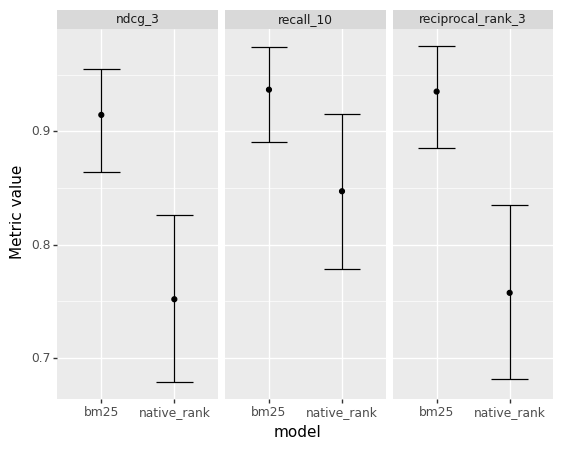

In [ ]:
from plotnine import *

print((ggplot(estimates) + 
 geom_point(aes("model", "median")) + 
 geom_errorbar(aes(x="model", ymin="low",ymax="high")) + 
 facet_wrap("metric") + labs(y="Metric value")
))

## Cleanup the environment

In [ ]:
vespa_docker.container.stop(timeout=600)
vespa_docker.container.remove()

In [ ]:
#|hide
nbdev_export()